<a href="https://colab.research.google.com/github/AlbertoAlaldu/SRP/blob/main/Scripts_Article_VPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Normalization '-f' not recognized. Using 'tanh'.

Using normalization: tanh

2D ISING MODEL SIMULATION - PVP FRAMEWORK
Lattice: 40×40 = 1600 spins
J = 1.0, kB = 1.0
Exact Tc (Onsager): 2.2692
βc = 1/Tc = 0.4407
ρ Normalization: tanh
Theoretical ρc: 0.4142
T Range: [1.5, 3.5]
ρ Range: [0.278, 0.583]
Temperatures: 35, Realizations: 25
-----------------------------------------------------------------
Realization 1/25... ✓
Realization 2/25... ✓
Realization 3/25... ✓
Realization 4/25... ✓
Realization 5/25... ✓
Realization 6/25... ✓
Realization 7/25... ✓
Realization 8/25... ✓
Realization 9/25... ✓
Realization 10/25... ✓
Realization 11/25... ✓
Realization 12/25... ✓
Realization 13/25... ✓
Realization 14/25... ✓
Realization 15/25... ✓
Realization 16/25... ✓
Realization 17/25... ✓
Realization 18/25... ✓
Realization 19/25... ✓
Realization 20/25... ✓
Realization 21/25... ✓
Realization 22/25... ✓
Realization 23/25... ✓
Realization 24/25... ✓
Realization 25/25... ✓
---------------------------------

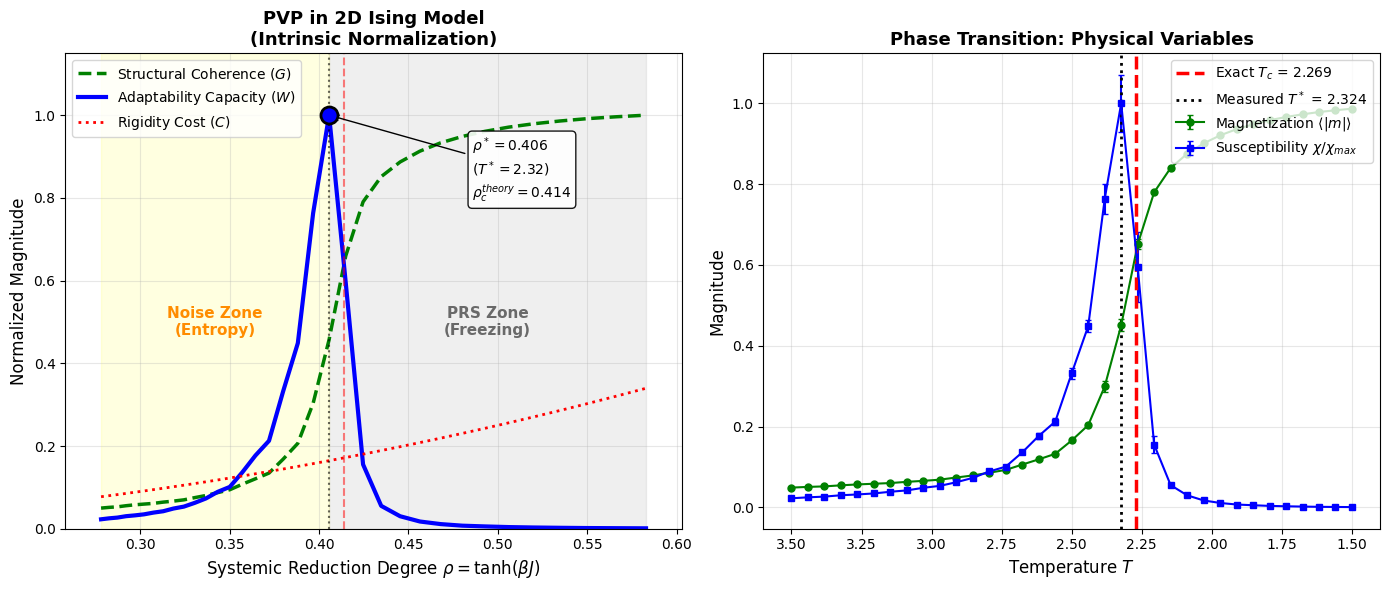


SUMMARY FOR PUBLICATION:
Model: 2D Ising, Algorithm: Checkerboard Metropolis
Normalization: ρ = tanh(βJ)
Critical Temperature:
  Tc (Onsager) = 2.2692
  T* (measured) = 2.3235
PVP Optimal Point:
  ρc (theory)   = 0.4142
  ρ* (measured) = 0.4056


In [1]:
"""
2D Ising Model under the PVP Framework
Version with intrinsic normalization: ρ = tanh(βJ)

This version corrects the issue where ρ* depended on the simulated temperature
range. Now ρ is an intrinsic function of the system, independent of
arbitrary simulation parameters.

Paradox Systems - December 2025
"""

import numpy as np
import matplotlib.pyplot as plt


# =============================================================================
# SIMULATION CORE
# =============================================================================

def checkerboard_update(lattice, beta, color):
    """
    Vectorized checkerboard update.

    Simultaneously updates all "black" (color=0) or "white" (color=1)
    sites of the board. Valid because sites of the same color are not
    neighbors of each other.
    """
    N = lattice.shape[0]

    # Checkerboard mask
    i, j = np.ogrid[:N, :N]
    mask = ((i + j) % 2 == color)

    # Sum of 4 neighbors (periodic boundary conditions)
    neighbors = (np.roll(lattice, 1, axis=0) +
                 np.roll(lattice, -1, axis=0) +
                 np.roll(lattice, 1, axis=1) +
                 np.roll(lattice, -1, axis=1))

    # ΔE = 2 * s * Σ(neighbors)
    dE = 2 * lattice * neighbors

    # Metropolis Criterion
    prob_accept = np.exp(-beta * np.clip(dE, 0, None))
    random_vals = np.random.random((N, N))

    # Flip where accepted, only on sites of the current color
    flip = mask & ((dE <= 0) | (random_vals < prob_accept))
    lattice[flip] *= -1

    return lattice


def full_sweep(lattice, beta):
    """A full sweep = update blacks + update whites."""
    lattice = checkerboard_update(lattice, beta, 0)
    lattice = checkerboard_update(lattice, beta, 1)
    return lattice


def simulate_temperature(N, beta, n_equilib, n_measure, measure_every=2):
    """
    Simulate the system at a fixed temperature.

    Returns:
        m: average magnetization per spin
        chi: magnetic susceptibility
    """
    lattice = np.random.choice([-1, 1], size=(N, N))

    # Equilibration
    for _ in range(n_equilib):
        lattice = full_sweep(lattice, beta)

    # Measurement
    M_samples = []
    for _ in range(n_measure):
        for _ in range(measure_every):
            lattice = full_sweep(lattice, beta)
        M_samples.append(np.sum(lattice))

    M = np.array(M_samples, dtype=np.float64)

    # Statistics
    M_abs_mean = np.mean(np.abs(M))
    M2_mean = np.mean(M**2)

    m = M_abs_mean / (N * N)
    chi = beta * (M2_mean - M_abs_mean**2) / (N * N)

    return m, max(chi, 0)


# =============================================================================
# ρ MAPPING FUNCTIONS
# =============================================================================

def rho_tanh(beta, J=1.0):
    """
    Intrinsic normalization: ρ = tanh(βJ)

    Properties:
    - ρ ∈ [0, 1] for all β ≥ 0
    - ρ → 0 when T → ∞ (β → 0)
    - ρ → 1 when T → 0 (β → ∞)
    - Independent of arbitrary parameters
    - Interpretation: effective correlation between spins
    """
    return np.tanh(beta * J)


def rho_exponential(beta, J=1.0):
    """
    Alternative normalization: ρ = 1 - exp(-βJ)

    Similar to tanh but grows faster near the origin.
    """
    return 1.0 - np.exp(-beta * J)


def rho_linear(beta, beta_min, beta_max):
    """
    Linear normalization (range dependent - NOT RECOMMENDED for papers).
    """
    return (beta - beta_min) / (beta_max - beta_min)


# =============================================================================
# MAIN SIMULATION
# =============================================================================

def ising_pvp_simulation(normalization='tanh'):
    """
    Full simulation of the Ising model under the PVP framework.

    Args:
        normalization: 'tanh', 'exp', or 'linear'
    """

    # --- PARAMETERS ---
    N = 40                  # Lattice size
    n_temps = 35            # Number of temperatures
    n_equilib = 2000        # Equilibration sweeps
    n_measure = 400         # Measurements per temperature
    measure_every = 2       # Sweeps between measurements
    n_realizations = 25     # Realizations for averaging

    J = 1.0                 # Coupling constant
    kB = 1.0                # Boltzmann constant

    # Exact Critical Temperature (Onsager, 1944)
    Tc_exact = 2.0 * J / (kB * np.log(1 + np.sqrt(2)))  # ≈ 2.269
    beta_c = 1.0 / Tc_exact

    # Theoretical critical ρ depending on normalization
    if normalization == 'tanh':
        rho_c_theory = np.tanh(beta_c * J)
    elif normalization == 'exp':
        rho_c_theory = 1.0 - np.exp(-beta_c * J)
    else:
        rho_c_theory = None  # Range dependent

    # Temperature Range
    T_min, T_max = 1.5, 3.5
    temps = np.linspace(T_max, T_min, n_temps)
    betas = 1.0 / temps

    # Calculate ρ based on chosen normalization
    if normalization == 'tanh':
        rhos = rho_tanh(betas, J)
        rho_label = r'$\rho = \tanh(\beta J)$'
    elif normalization == 'exp':
        rhos = rho_exponential(betas, J)
        rho_label = r'$\rho = 1 - e^{-\beta J}$'
    else:  # linear
        rhos = rho_linear(betas, betas.min(), betas.max())
        rho_label = r'$\rho$ linear (range dependent)'

    # Arrays for results
    mag_all = np.zeros((n_realizations, n_temps))
    chi_all = np.zeros((n_realizations, n_temps))

    print("=" * 65)
    print("2D ISING MODEL SIMULATION - PVP FRAMEWORK")
    print("=" * 65)
    print(f"Lattice: {N}×{N} = {N*N} spins")
    print(f"J = {J}, kB = {kB}")
    print(f"Exact Tc (Onsager): {Tc_exact:.4f}")
    print(f"βc = 1/Tc = {beta_c:.4f}")
    print(f"ρ Normalization: {normalization}")
    if rho_c_theory:
        print(f"Theoretical ρc: {rho_c_theory:.4f}")
    print(f"T Range: [{T_min}, {T_max}]")
    print(f"ρ Range: [{rhos.min():.3f}, {rhos.max():.3f}]")
    print(f"Temperatures: {n_temps}, Realizations: {n_realizations}")
    print("-" * 65)

    # --- MAIN LOOP ---
    for r in range(n_realizations):
        print(f"Realization {r+1}/{n_realizations}...", end=" ", flush=True)

        for i, beta in enumerate(betas):
            m, chi = simulate_temperature(N, beta, n_equilib, n_measure, measure_every)
            mag_all[r, i] = m
            chi_all[r, i] = chi

        print("✓")

    # Average over realizations
    mag_mean = np.mean(mag_all, axis=0)
    chi_mean = np.mean(chi_all, axis=0)
    mag_std = np.std(mag_all, axis=0) / np.sqrt(n_realizations)
    chi_std = np.std(chi_all, axis=0) / np.sqrt(n_realizations)

    # --- PVP CURVE CONSTRUCTION ---

    # G(ρ): Gain = Magnetization
    G = mag_mean / np.max(mag_mean)

    # W(ρ): Viability = Susceptibility
    W = chi_mean / np.max(chi_mean)

    # C(ρ): Cost = Convex increasing function
    C = rhos**2

    # Find ρ* (maximum susceptibility)
    idx_opt = np.argmax(chi_mean)
    rho_opt = rhos[idx_opt]
    T_opt = temps[idx_opt]
    beta_opt = betas[idx_opt]

    # Results
    print("-" * 65)
    print("RESULTS:")
    print(f"  Measured T* = {T_opt:.4f}")
    print(f"  Exact Tc    = {Tc_exact:.4f}")
    print(f"  T Error: {100*abs(T_opt - Tc_exact)/Tc_exact:.2f}%")
    print()
    print(f"  Measured ρ* = {rho_opt:.4f}")
    if rho_c_theory:
        print(f"  Theoretical ρc = {rho_c_theory:.4f}")
        print(f"  ρ Error: {100*abs(rho_opt - rho_c_theory)/rho_c_theory:.2f}%")
    print("=" * 65)

    # --- PLOTTING ---

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # ===== Left Panel: PVP Space =====
    ax1 = axes[0]

    ax1.plot(rhos, G, '--', color='green', linewidth=2.5,
             label='Structural Coherence ($G$)')
    ax1.plot(rhos, W, '-', color='blue', linewidth=3,
             label='Adaptability Capacity ($W$)')
    ax1.plot(rhos, C, ':', color='red', linewidth=2,
             label='Rigidity Cost ($C$)')

    # Mark measured optimal point
    ax1.axvline(rho_opt, color='black', linestyle=':', alpha=0.6)
    ax1.scatter([rho_opt], [W[idx_opt]], color='blue', s=150, zorder=5,
                edgecolors='black', linewidths=2)

    # Mark theoretical ρc if it exists
    if rho_c_theory:
        ax1.axvline(rho_c_theory, color='red', linestyle='--', alpha=0.5, linewidth=1.5)

    # Annotation
    annotation_text = f'$\\rho^* = {rho_opt:.3f}$\n$(T^* = {T_opt:.2f})$'
    if rho_c_theory:
        annotation_text += f'\n$\\rho_c^{{theory}} = {rho_c_theory:.3f}$'

    ax1.annotate(annotation_text,
                 xy=(rho_opt, W[idx_opt]),
                 xytext=(rho_opt + 0.08, W[idx_opt] - 0.2),
                 fontsize=10, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
                 arrowprops=dict(arrowstyle='->', color='black'))

    # Colored zones
    ax1.axvspan(rhos.min(), rho_opt, color='yellow', alpha=0.12)
    ax1.axvspan(rho_opt, rhos.max(), color='gray', alpha=0.12)

    # Zone labels
    zone_y = 0.5
    ax1.text((rhos.min() + rho_opt) / 2, zone_y, "Noise Zone\n(Entropy)",
             fontsize=11, color='darkorange', fontweight='bold',
             ha='center', va='center')
    ax1.text((rhos.max() + rho_opt) / 2, zone_y, "PRS Zone\n(Freezing)",
             fontsize=11, color='dimgray', fontweight='bold',
             ha='center', va='center')

    ax1.set_xlabel(f'Systemic Reduction Degree {rho_label}', fontsize=12)
    ax1.set_ylabel('Normalized Magnitude', fontsize=12)
    ax1.set_title('PVP in 2D Ising Model\n(Intrinsic Normalization)',
                  fontsize=13, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(rhos.min() - 0.02, rhos.max() + 0.02)
    ax1.set_ylim(0, 1.15)

    # ===== Right Panel: Physical Variables =====
    ax2 = axes[1]

    ax2.errorbar(temps, mag_mean, yerr=mag_std, fmt='o-', color='green',
                 markersize=5, capsize=2, linewidth=1.5,
                 label='Magnetization $\\langle |m| \\rangle$')

    chi_norm = chi_mean / np.max(chi_mean)
    chi_std_norm = chi_std / np.max(chi_mean)
    ax2.errorbar(temps, chi_norm, yerr=chi_std_norm, fmt='s-', color='blue',
                 markersize=5, capsize=2, linewidth=1.5,
                 label='Susceptibility $\\chi / \\chi_{max}$')

    ax2.axvline(Tc_exact, color='red', linestyle='--', linewidth=2.5,
                label=f'Exact $T_c$ = {Tc_exact:.3f}')
    ax2.axvline(T_opt, color='black', linestyle=':', linewidth=2,
                label=f'Measured $T^*$ = {T_opt:.3f}')

    ax2.set_xlabel('Temperature $T$', fontsize=12)
    ax2.set_ylabel('Magnitude', fontsize=12)
    ax2.set_title('Phase Transition: Physical Variables', fontsize=13, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.invert_xaxis()

    plt.tight_layout()

    # Save
    filename_base = f'ising_pvp_{normalization}'
    plt.savefig(f'{filename_base}.png', dpi=150, bbox_inches='tight')
    plt.savefig(f'{filename_base}.pdf', bbox_inches='tight')
    print(f"\nFigures saved: {filename_base}.png/pdf")

    # Save data
    np.savez(f'{filename_base}_data.npz',
             N=N, J=J, temps=temps, rhos=rhos, betas=betas,
             normalization=normalization,
             magnetization=mag_mean, magnetization_std=mag_std,
             susceptibility=chi_mean, susceptibility_std=chi_std,
             G=G, C=C, W=W,
             rho_opt=rho_opt, T_opt=T_opt,
             Tc_exact=Tc_exact, rho_c_theory=rho_c_theory)
    print(f"Data saved: {filename_base}_data.npz")

    plt.show()

    return {
        'temps': temps,
        'rhos': rhos,
        'mag': mag_mean,
        'chi': chi_mean,
        'G': G, 'C': C, 'W': W,
        'rho_opt': rho_opt,
        'T_opt': T_opt,
        'Tc_exact': Tc_exact,
        'rho_c_theory': rho_c_theory
    }


# =============================================================================
# EXECUTION
# =============================================================================

if __name__ == "__main__":
    import sys

    # Select normalization from command line or use tanh by default
    if len(sys.argv) > 1:
        norm = sys.argv[1]
        if norm not in ['tanh', 'exp', 'linear']:
            print(f"Normalization '{norm}' not recognized. Using 'tanh'.")
            norm = 'tanh'
    else:
        norm = 'tanh'

    print(f"\nUsing normalization: {norm}\n")
    results = ising_pvp_simulation(normalization=norm)

    # Final Summary
    print("\n" + "=" * 65)
    print("SUMMARY FOR PUBLICATION:")
    print("=" * 65)
    print(f"Model: 2D Ising, Algorithm: Checkerboard Metropolis")
    print(f"Normalization: ρ = tanh(βJ)" if norm == 'tanh' else f"Normalization: {norm}")
    print(f"Critical Temperature:")
    print(f"  Tc (Onsager) = {results['Tc_exact']:.4f}")
    print(f"  T* (measured) = {results['T_opt']:.4f}")
    print(f"PVP Optimal Point:")
    print(f"  ρc (theory)   = {results['rho_c_theory']:.4f}")
    print(f"  ρ* (measured) = {results['rho_opt']:.4f}")
    print("=" * 65)

In [2]:
import numpy as np

class VPPRobotController:
    def __init__(self, initial_rho=0.5, adaptation_rate=0.01):
        self.rho = initial_rho
        self.adaptation_rate = adaptation_rate

        # Historial para estimación de gradientes
        self.history = []  # Lista de (rho, G, C)
        self.rho_history = [initial_rho]

        # Parámetros de estimación
        self.window_size = 20
        self.min_samples_for_gradient = 5

    def update(self, G_measurement, C_measurement):
        """Actualización online con estimación robusta de gradientes"""

        # Guardar medición
        self.history.append((self.rho, G_measurement, C_measurement))

        # Mantener ventana limitada
        if len(self.history) > self.window_size:
            self.history = self.history[-self.window_size:]

        # Necesitamos suficientes muestras con variación en ρ
        if len(self.history) >= self.min_samples_for_gradient:
            # Extraer datos
            rhos = np.array([h[0] for h in self.history])
            Gs = np.array([h[1] for h in self.history])
            Cs = np.array([h[2] for h in self.history])

            # Solo estimar si hay variación en ρ
            rho_var = np.var(rhos)
            if rho_var > 1e-6:
                # Regresión lineal simple: dG/dρ ≈ cov(G,ρ)/var(ρ)
                dG_drho = np.cov(Gs, rhos)[0,1] / rho_var
                dC_drho = np.cov(Cs, rhos)[0,1] / rho_var

                # Regla VPP: moverse hacia dG/dρ = dC/dρ
                gradient_diff = dG_drho - dC_drho

                # Ajuste proporcional al desequilibrio
                delta_rho = self.adaptation_rate * np.sign(gradient_diff)
                self.rho = np.clip(self.rho + delta_rho, 0.05, 0.95)

        self.rho_history.append(self.rho)
        return self.rho

    def emergency_response(self, sudden_change_detected):
        """Respuesta de emergencia: aumentar apertura (reducir ρ)"""
        if sudden_change_detected:
            old_rho = self.rho
            self.rho = max(0.05, self.rho * 0.5)  # Actualiza self.rho
            print(f"EMERGENCIA: ρ {old_rho:.3f} → {self.rho:.3f}")

            # Limpiar historial (el entorno cambió)
            self.history = []

        return self.rho

    def get_viability_estimate(self):
        """Estima W actual basado en mediciones recientes"""
        if len(self.history) < 3:
            return None
        recent = self.history[-3:]
        G_avg = np.mean([h[1] for h in recent])
        C_avg = np.mean([h[2] for h in recent])
        return G_avg - C_avg

PUMP-LEAK MODEL (SIMPLIFIED TOSTESON-HOFFMAN)
Parameters:
  Stability threshold: ρ_threshold = 0.3
  Cost weighting:      λ = 0.7

Results:
  ρ* (optimal) = 0.485
  G(ρ*)        = 0.976
  C(ρ*)        = 0.172
  W(ρ*)        = 0.855

Zones:
  Lysis (G < 0.5):      ρ < 0.30
  PRS (dW/dρ < -0.3):   ρ > 0.52

Figures saved: pump_leak_pvp.png/pdf


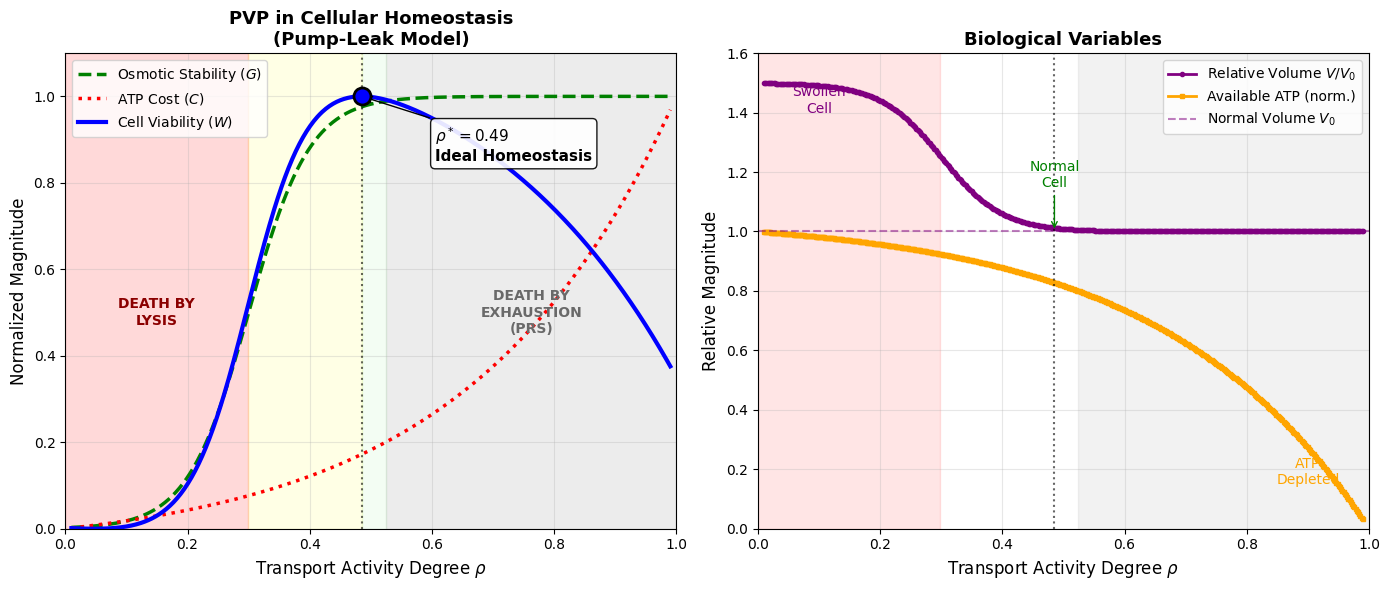


PUBLICATION SUMMARY:
Model: Pump-Leak (Simplified Tosteson-Hoffman)
Optimal ρ* = 0.485
Lysis Zone: ρ < 0.30
PRS Zone:   ρ > 0.52


In [3]:
"""
PVP Simulation: Biological Regime
Pump-Leak Model (Simplified Tosteson-Hoffman)

This model captures the essence of the pump-leak balance in cells:
- The Na⁺/K⁺-ATPase pump maintains ion gradients (spends ATP)
- Passive leak tends to dissipate gradients
- Cell volume depends on osmotic balance

ρ = active pumping rate / passive leak rate

Paradox Systems - December 2025
"""

import numpy as np
import matplotlib.pyplot as plt


def pump_leak_model():
    """
    Simplified model of cellular homeostasis.

    Variables:
    - ρ ∈ [0,1]: Degree of active transport activity
      ρ = 0: No pumping (cell swells and lyses)
      ρ = 1: Max pumping (depletes ATP)

    Functions:
    - G(ρ): Gain - Cell volume stability (avoiding lysis/crenation)
    - C(ρ): Cost - Metabolic cost (ATP consumption)
    - W(ρ): Viability = G - λC
    """

    # Model Parameters
    rho = np.linspace(0.01, 0.99, 500)

    # =========================================================================
    # G(ρ): GAIN - Osmotic Stability
    # =========================================================================
    # Cell volume V(ρ) depends on osmotic balance.
    # Without pumping (ρ→0): Na⁺ enters, water follows, cell swells → lysis
    # With moderate pumping: V stabilizes in physiological range
    # Excess pumping: little additional benefit (saturation)
    #
    # We model G as a sigmoid: transition from unstable to stable

    rho_threshold = 0.30  # Minimum threshold for stability
    steepness = 20        # How abrupt the transition is

    G = 1.0 / (1.0 + np.exp(-steepness * (rho - rho_threshold)))

    # =========================================================================
    # C(ρ): COST - ATP Consumption
    # =========================================================================
    # The Na⁺/K⁺-ATPase pump consumes 1 ATP per cycle (3 Na⁺ out, 2 K⁺ in)
    # The cost grows more than linearly because:
    # - At high ρ, you pump against steeper gradients
    # - Maintaining ρ≈1 requires infinite ATP (thermodynamic limit)
    #
    # We model C as a truncated exponential (convex, increasing)

    C = (np.exp(3.0 * rho) - 1) / (np.exp(3.0) - 1)  # Normalized to [0,1]

    # =========================================================================
    # W(ρ): VIABILITY
    # =========================================================================
    # W = G - λC where λ weights the importance of energy cost
    #
    # High λ: cell in nutrient-poor environment (scarce ATP)
    # Low λ: cell in rich environment (can afford to "spend")

    lambda_cost = 0.7  # Cost weighting

    W = G - lambda_cost * C

    # =========================================================================
    # FIND OPTIMUM
    # =========================================================================
    idx_opt = np.argmax(W)
    rho_opt = rho[idx_opt]
    W_opt = W[idx_opt]
    G_opt = G[idx_opt]
    C_opt = C[idx_opt]

    # Normalize W for visualization (maintaining shape)
    W_norm = (W - W.min()) / (W.max() - W.min())

    # =========================================================================
    # PHYSICS-BASED ZONES
    # =========================================================================
    # Lysis Zone: where G < 0.5 (unstable volume)
    rho_lysis = rho[G < 0.5].max() if (G < 0.5).any() else 0

    # Exhaustion Zone: where dW/dρ < -threshold (PRS)
    dW = np.gradient(W, rho)
    rho_prs = rho[dW < -0.3].min() if (dW < -0.3).any() else 1

    # =========================================================================
    # RESULTS
    # =========================================================================
    print("=" * 60)
    print("PUMP-LEAK MODEL (SIMPLIFIED TOSTESON-HOFFMAN)")
    print("=" * 60)
    print(f"Parameters:")
    print(f"  Stability threshold: ρ_threshold = {rho_threshold}")
    print(f"  Cost weighting:      λ = {lambda_cost}")
    print(f"\nResults:")
    print(f"  ρ* (optimal) = {rho_opt:.3f}")
    print(f"  G(ρ*)        = {G_opt:.3f}")
    print(f"  C(ρ*)        = {C_opt:.3f}")
    print(f"  W(ρ*)        = {W_opt:.3f}")
    print(f"\nZones:")
    print(f"  Lysis (G < 0.5):      ρ < {rho_lysis:.2f}")
    print(f"  PRS (dW/dρ < -0.3):   ρ > {rho_prs:.2f}")
    print("=" * 60)

    # =========================================================================
    # PLOTTING
    # =========================================================================
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # ----- Left Panel: PVP Space -----
    ax1 = axes[0]

    ax1.plot(rho, G, '--', color='green', linewidth=2.5,
             label='Osmotic Stability ($G$)')
    ax1.plot(rho, C, ':', color='red', linewidth=2.5,
             label='ATP Cost ($C$)')
    ax1.plot(rho, W_norm, '-', color='blue', linewidth=3,
             label='Cell Viability ($W$)')

    # Optimal Point
    ax1.axvline(rho_opt, color='black', linestyle=':', alpha=0.6)
    ax1.scatter([rho_opt], [W_norm[idx_opt]], color='blue', s=150,
                zorder=5, edgecolors='black', linewidths=2)

    # Annotation
    ax1.annotate(f'$\\rho^* = {rho_opt:.2f}$\nIdeal Homeostasis',
                 xy=(rho_opt, W_norm[idx_opt]),
                 xytext=(rho_opt + 0.12, W_norm[idx_opt] - 0.15),
                 fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
                 arrowprops=dict(arrowstyle='->', color='black'))

    # Colored Zones (calculated, not hardcoded)
    ax1.axvspan(0, rho_lysis, color='red', alpha=0.15)
    ax1.axvspan(rho_prs, 1, color='gray', alpha=0.15)
    ax1.axvspan(rho_lysis, rho_opt, color='yellow', alpha=0.1)
    ax1.axvspan(rho_opt, rho_prs, color='lightgreen', alpha=0.1)

    # Zone Labels
    ax1.text(rho_lysis/2, 0.5, "DEATH BY\nLYSIS",
             fontsize=10, color='darkred', fontweight='bold',
             ha='center', va='center')
    ax1.text((rho_prs + 1)/2, 0.5, "DEATH BY\nEXHAUSTION\n(PRS)",
             fontsize=10, color='dimgray', fontweight='bold',
             ha='center', va='center')

    ax1.set_xlabel('Transport Activity Degree $\\rho$', fontsize=12)
    ax1.set_ylabel('Normalized Magnitude', fontsize=12)
    ax1.set_title('PVP in Cellular Homeostasis\n(Pump-Leak Model)',
                  fontsize=13, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1.1)

    # ----- Right Panel: Biological Interpretation -----
    ax2 = axes[1]

    # Relative Cell Volume (Schematic)
    # V/V0 > 1: swollen, V/V0 < 1: crenated, V/V0 = 1: normal
    V_rel = 1.5 - 0.5 * G  # Swollen when G is low

    # Available Energy (ATP)
    ATP = 1 - C  # Normalized: Available ATP decreases with C

    ax2.plot(rho, V_rel, 'o-', color='purple', linewidth=2, markersize=3,
             label='Relative Volume $V/V_0$')
    ax2.plot(rho, ATP, 's-', color='orange', linewidth=2, markersize=3,
             label='Available ATP (norm.)')
    ax2.axhline(1.0, color='purple', linestyle='--', alpha=0.5,
                label='Normal Volume $V_0$')

    ax2.axvline(rho_opt, color='black', linestyle=':', alpha=0.6)
    ax2.axvspan(0, rho_lysis, color='red', alpha=0.1)
    ax2.axvspan(rho_prs, 1, color='gray', alpha=0.1)

    # State Annotations
    ax2.annotate('Swollen\nCell', xy=(0.1, 1.4), fontsize=10,
                 ha='center', color='purple')
    ax2.annotate('Normal\nCell', xy=(rho_opt, 1.0), fontsize=10,
                 xytext=(rho_opt, 1.15), ha='center', color='green',
                 arrowprops=dict(arrowstyle='->', color='green'))
    ax2.annotate('ATP\nDepleted', xy=(0.9, 0.15), fontsize=10,
                 ha='center', color='orange')

    ax2.set_xlabel('Transport Activity Degree $\\rho$', fontsize=12)
    ax2.set_ylabel('Relative Magnitude', fontsize=12)
    ax2.set_title('Biological Variables', fontsize=13, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1.6)

    plt.tight_layout()
    plt.savefig('pump_leak_pvp.png', dpi=150, bbox_inches='tight')
    plt.savefig('pump_leak_pvp.pdf', bbox_inches='tight')
    print("\nFigures saved: pump_leak_pvp.png/pdf")

    plt.show()

    return {
        'rho': rho,
        'G': G, 'C': C, 'W': W,
        'rho_opt': rho_opt,
        'rho_lysis': rho_lysis,
        'rho_prs': rho_prs,
        'lambda': lambda_cost
    }


def sensitivity_analysis():
    """
    Sensitivity Analysis: How does ρ* change with λ?
    """
    rho = np.linspace(0.01, 0.99, 500)

    # G and C fixed
    G = 1.0 / (1.0 + np.exp(-20 * (rho - 0.30)))
    C = (np.exp(3.0 * rho) - 1) / (np.exp(3.0) - 1)

    lambdas = np.linspace(0.3, 1.5, 50)
    rho_opts = []

    for lam in lambdas:
        W = G - lam * C
        idx = np.argmax(W)
        rho_opts.append(rho[idx])

    plt.figure(figsize=(8, 5))
    plt.plot(lambdas, rho_opts, 'o-', color='blue', linewidth=2)
    plt.xlabel('Cost Weighting $\\lambda$', fontsize=12)
    plt.ylabel('Optimal $\\rho^*$', fontsize=12)
    plt.title('Sensitivity of Optimum to Energy Cost', fontsize=13)
    plt.grid(True, alpha=0.3)
    plt.axhline(0.62, color='red', linestyle='--', alpha=0.5,
                label='$\\rho^* = 0.62$ (original paper)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('pump_leak_sensitivity.png', dpi=150)
    plt.show()

    return lambdas, rho_opts


if __name__ == "__main__":
    results = pump_leak_model()

    print("\n" + "=" * 60)
    print("PUBLICATION SUMMARY:")
    print("=" * 60)
    print(f"Model: Pump-Leak (Simplified Tosteson-Hoffman)")
    print(f"Optimal ρ* = {results['rho_opt']:.3f}")
    print(f"Lysis Zone: ρ < {results['rho_lysis']:.2f}")
    print(f"PRS Zone:   ρ > {results['rho_prs']:.2f}")
    print("=" * 60)

    # Optional: sensitivity analysis
    # sensitivity_analysis()

PVP SIMULATION IN WATTS-STROGATZ NETWORKS
Nodes: 200, Neighbors: 6
Values of p: 40, Samples per point: 20

References:
  Lattice (p=0): C = 0.6000, L = 17.09
  Random (p=1):  C = 0.0244, L = 3.14
-----------------------------------------------------------------
Simulating networks...
  10/40 completed
  20/40 completed
  30/40 completed
  40/40 completed
Simulation completed.

RESULTS:
  Optimal ρ* = 0.9633
  Corresponding p* = 0.0367
  Clustering at ρ* = 0.5365
  Path length at ρ* = 5.75
  G(ρ*) = 0.890
  C(ρ*) = 0.187

Figures saved: watts_strogatz_pvp.png/pdf


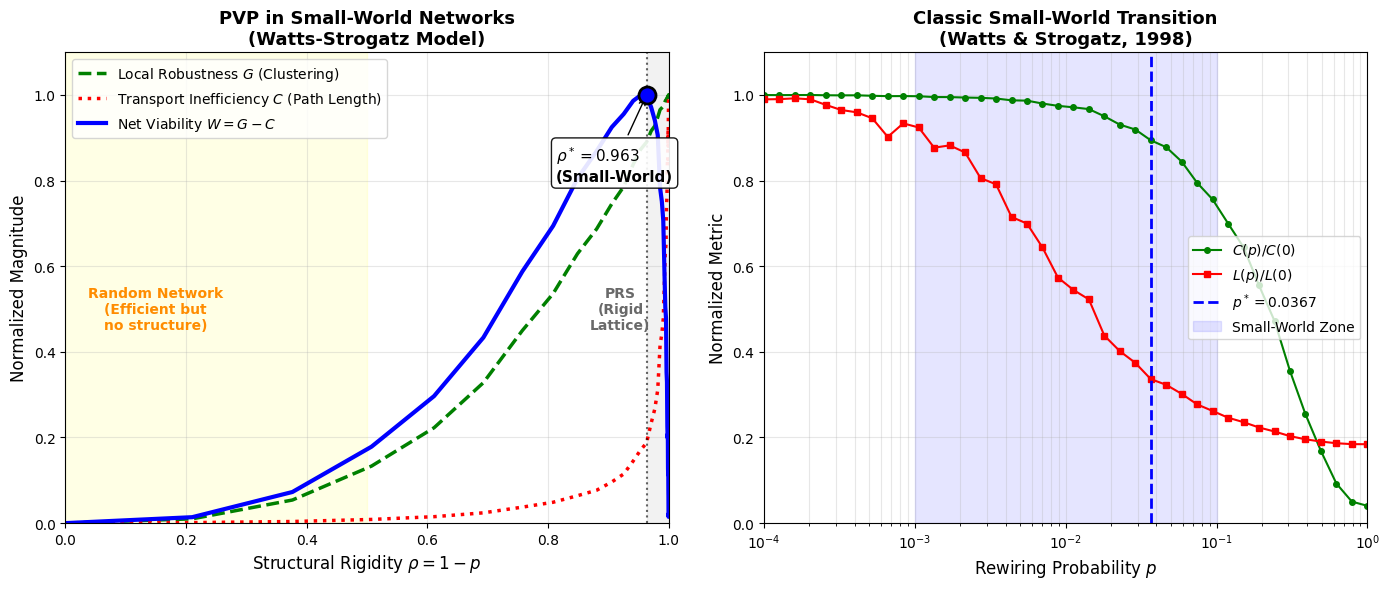

Data saved: watts_strogatz_pvp_data.npz

PUBLICATION SUMMARY:
Model: Watts-Strogatz (N=200, k=6)
Optimal ρ* = 0.9633
Corresponding p* = 0.0367
Interpretation: The optimum is close to the lattice regime
                but requires ~3.67% of random shortcuts


In [4]:
"""
PVP Simulation: Topological Regime
Small-World Network Model (Watts-Strogatz)

In this model:
- ρ = 1 - p, where p is the rewiring probability
- ρ = 0: Random network (high efficiency, low structure)
- ρ = 1: Regular/Lattice network (high structure, low efficiency)

Viability combines:
- G(ρ): Clustering (local robustness, redundancy)
- C(ρ): Path length (communication cost)

The "sweet spot" for small-worldness is where there is high clustering AND low path length.

Paradox Systems - December 2025
"""

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm  # Optional, for progress bar


def watts_strogatz_pvp():
    """
    PVP Simulation in Watts-Strogatz networks.
    """

    # =========================================================================
    # PARAMETERS
    # =========================================================================
    N = 200           # Number of nodes
    k = 6             # Initial neighbors (must be even)
    n_probs = 40      # Number of p values to test
    n_samples = 20    # Samples per p value (to reduce noise)

    # Range of rewiring probabilities
    # We use a logarithmic scale to capture the transition
    p_values = np.logspace(-4, 0, n_probs)  # From 0.0001 to 1

    # =========================================================================
    # REFERENCE VALUES
    # =========================================================================
    # Regular Lattice (p=0): max clustering, max path length
    G_lattice = nx.watts_strogatz_graph(N, k, 0)
    C_lattice = nx.average_clustering(G_lattice)
    L_lattice = nx.average_shortest_path_length(G_lattice)

    # Equivalent Random Network (p=1): low clustering, low path length
    G_random = nx.watts_strogatz_graph(N, k, 1)
    C_random = nx.average_clustering(G_random)
    L_random = nx.average_shortest_path_length(G_random)

    print("=" * 65)
    print("PVP SIMULATION IN WATTS-STROGATZ NETWORKS")
    print("=" * 65)
    print(f"Nodes: {N}, Neighbors: {k}")
    print(f"Values of p: {n_probs}, Samples per point: {n_samples}")
    print(f"\nReferences:")
    print(f"  Lattice (p=0): C = {C_lattice:.4f}, L = {L_lattice:.2f}")
    print(f"  Random (p=1):  C = {C_random:.4f}, L = {L_random:.2f}")
    print("-" * 65)

    # =========================================================================
    # SIMULATION
    # =========================================================================
    clustering_mean = np.zeros(n_probs)
    clustering_std = np.zeros(n_probs)
    path_length_mean = np.zeros(n_probs)
    path_length_std = np.zeros(n_probs)

    print("Simulating networks...")

    for i, p in enumerate(p_values):
        C_samples = []
        L_samples = []

        for _ in range(n_samples):
            G = nx.watts_strogatz_graph(N, k, p)
            C_samples.append(nx.average_clustering(G))

            # Check connectivity before calculating path length
            if nx.is_connected(G):
                L_samples.append(nx.average_shortest_path_length(G))
            else:
                # For disconnected graphs, use the largest connected component
                largest_cc = max(nx.connected_components(G), key=len)
                subgraph = G.subgraph(largest_cc)
                L_samples.append(nx.average_shortest_path_length(subgraph))

        clustering_mean[i] = np.mean(C_samples)
        clustering_std[i] = np.std(C_samples)
        path_length_mean[i] = np.mean(L_samples)
        path_length_std[i] = np.std(L_samples)

        # Progress
        if (i + 1) % 10 == 0:
            print(f"  {i+1}/{n_probs} completed")

    print("Simulation completed.\n")

    # =========================================================================
    # DEFINE ρ AND PVP METRICS
    # =========================================================================

    # ρ = Structural Rigidity = 1 - p
    # ρ = 0: Random network
    # ρ = 1: Regular lattice
    rho = 1 - p_values

    # G(ρ): Gain = Normalized Clustering
    # G = 1 when C = C_lattice, G ≈ 0 when C = C_random
    G_norm = (clustering_mean - C_random) / (C_lattice - C_random)
    G_norm = np.clip(G_norm, 0, 1)

    # C(ρ): Cost = Normalized Path length (inverted so high ρ = high cost)
    # We want C = 0 when L = L_random (efficient)
    # and C = 1 when L = L_lattice (inefficient)
    L_norm = (path_length_mean - L_random) / (L_lattice - L_random)
    L_norm = np.clip(L_norm, 0, 1)

    # =========================================================================
    # VIABILITY W(ρ)
    # =========================================================================
    # Option 1: W = G - λC (Standard PVP form)
    lambda_cost = 1.0
    W_additive = G_norm - lambda_cost * L_norm

    # Option 2: W = G / L (small-worldness ratio)
    # Avoid division by zero
    W_ratio = G_norm / (L_norm + 0.01)

    # Option 3: W = G * (1 - L) (product)
    W_product = G_norm * (1 - L_norm)

    # We use the additive form for consistency with the rest of the paper
    W = W_additive
    W_norm = (W - W.min()) / (W.max() - W.min())

    # =========================================================================
    # FIND OPTIMUM
    # =========================================================================
    idx_opt = np.argmax(W)
    rho_opt = rho[idx_opt]
    p_opt = p_values[idx_opt]

    print("=" * 65)
    print("RESULTS:")
    print(f"  Optimal ρ* = {rho_opt:.4f}")
    print(f"  Corresponding p* = {p_opt:.4f}")
    print(f"  Clustering at ρ* = {clustering_mean[idx_opt]:.4f}")
    print(f"  Path length at ρ* = {path_length_mean[idx_opt]:.2f}")
    print(f"  G(ρ*) = {G_norm[idx_opt]:.3f}")
    print(f"  C(ρ*) = {L_norm[idx_opt]:.3f}")
    print("=" * 65)

    # =========================================================================
    # PLOTTING
    # =========================================================================
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # ----- Left Panel: PVP Space -----
    ax1 = axes[0]

    # Sort by increasing ρ for plotting
    sort_idx = np.argsort(rho)
    rho_s = rho[sort_idx]
    G_s = G_norm[sort_idx]
    L_s = L_norm[sort_idx]
    W_s = W_norm[sort_idx]

    ax1.plot(rho_s, G_s, '--', color='green', linewidth=2.5,
             label='Local Robustness $G$ (Clustering)')
    ax1.plot(rho_s, L_s, ':', color='red', linewidth=2.5,
             label='Transport Inefficiency $C$ (Path Length)')
    ax1.plot(rho_s, W_s, '-', color='blue', linewidth=3,
             label='Net Viability $W = G - C$')

    # Optimal Point
    idx_opt_sorted = np.argmax(W_s)
    rho_opt_s = rho_s[idx_opt_sorted]

    ax1.axvline(rho_opt_s, color='black', linestyle=':', alpha=0.6)
    ax1.scatter([rho_opt_s], [W_s[idx_opt_sorted]], color='blue', s=150,
                zorder=5, edgecolors='black', linewidths=2)

    # Annotation
    ax1.annotate(f'$\\rho^* = {rho_opt_s:.3f}$\n(Small-World)',
                 xy=(rho_opt_s, W_s[idx_opt_sorted]),
                 xytext=(rho_opt_s - 0.15, W_s[idx_opt_sorted] - 0.2),
                 fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
                 arrowprops=dict(arrowstyle='->', color='black'))

    # Zones
    ax1.axvspan(0, 0.5, color='yellow', alpha=0.1)
    ax1.axvspan(rho_opt_s, 1, color='gray', alpha=0.1)

    ax1.text(0.15, 0.5, "Random Network\n(Efficient but\nno structure)",
             fontsize=10, color='darkorange', fontweight='bold',
             ha='center', va='center')
    ax1.text(0.92, 0.5, "PRS\n(Rigid\nLattice)",
             fontsize=10, color='dimgray', fontweight='bold',
             ha='center', va='center')

    ax1.set_xlabel('Structural Rigidity $\\rho = 1 - p$', fontsize=12)
    ax1.set_ylabel('Normalized Magnitude', fontsize=12)
    ax1.set_title('PVP in Small-World Networks\n(Watts-Strogatz Model)',
                  fontsize=13, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1.1)

    # ----- Right Panel: Logarithmic p Scale -----
    ax2 = axes[1]

    # Plot vs p on log scale (classic way to present Watts-Strogatz)
    ax2.semilogx(p_values, clustering_mean / C_lattice, 'o-', color='green',
                 markersize=4, linewidth=1.5, label='$C(p) / C(0)$')
    ax2.semilogx(p_values, path_length_mean / L_lattice, 's-', color='red',
                 markersize=4, linewidth=1.5, label='$L(p) / L(0)$')

    # Mark small-world region
    ax2.axvline(p_opt, color='blue', linestyle='--', linewidth=2,
                label=f'$p^* = {p_opt:.4f}$')
    ax2.axvspan(0.001, 0.1, color='blue', alpha=0.1, label='Small-World Zone')

    ax2.set_xlabel('Rewiring Probability $p$', fontsize=12)
    ax2.set_ylabel('Normalized Metric', fontsize=12)
    ax2.set_title('Classic Small-World Transition\n(Watts & Strogatz, 1998)',
                  fontsize=13, fontweight='bold')
    ax2.legend(loc='right', fontsize=10)
    ax2.grid(True, alpha=0.3, which='both')
    ax2.set_xlim(1e-4, 1)
    ax2.set_ylim(0, 1.1)

    plt.tight_layout()
    plt.savefig('watts_strogatz_pvp.png', dpi=150, bbox_inches='tight')
    plt.savefig('watts_strogatz_pvp.pdf', bbox_inches='tight')
    print("\nFigures saved: watts_strogatz_pvp.png/pdf")

    plt.show()

    # Save data
    np.savez('watts_strogatz_pvp_data.npz',
             N=N, k=k,
             p_values=p_values, rho=rho,
             clustering=clustering_mean, clustering_std=clustering_std,
             path_length=path_length_mean, path_length_std=path_length_std,
             G=G_norm, C=L_norm, W=W,
             rho_opt=rho_opt, p_opt=p_opt,
             C_lattice=C_lattice, L_lattice=L_lattice,
             C_random=C_random, L_random=L_random)
    print("Data saved: watts_strogatz_pvp_data.npz")

    return {
        'rho': rho,
        'p': p_values,
        'G': G_norm,
        'C': L_norm,
        'W': W,
        'rho_opt': rho_opt,
        'p_opt': p_opt
    }


if __name__ == "__main__":
    results = watts_strogatz_pvp()

    print("\n" + "=" * 65)
    print("PUBLICATION SUMMARY:")
    print("=" * 65)
    print(f"Model: Watts-Strogatz (N=200, k=6)")
    print(f"Optimal ρ* = {results['rho_opt']:.4f}")
    print(f"Corresponding p* = {results['p_opt']:.4f}")
    print(f"Interpretation: The optimum is close to the lattice regime")
    print(f"                but requires ~{results['p_opt']*100:.2f}% of random shortcuts")
    print("=" * 65)


--- RUNNING STANDARD MODEL ---


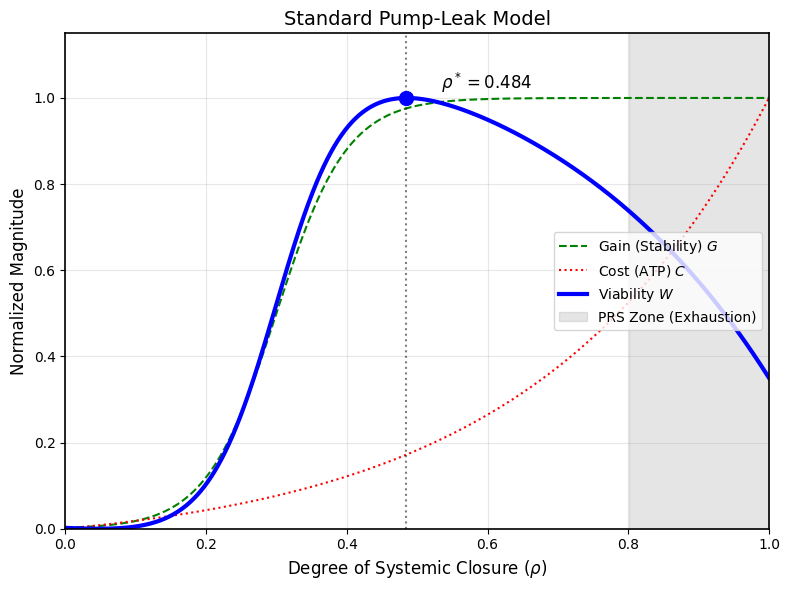

Standard optimum found at rho = 0.484

--- RUNNING SENSITIVITY ANALYSIS ---


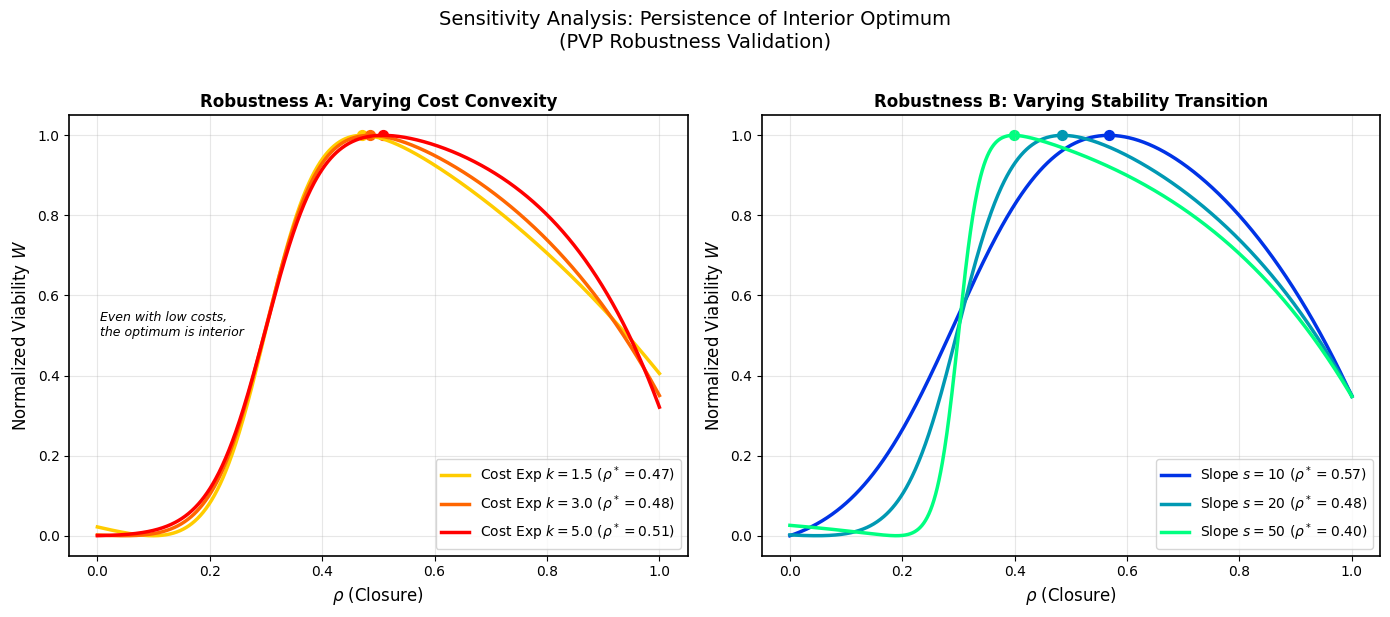

Robustness figure saved as 'robustness_check.png'

--- GENERATING OPTIMA HEATMAP ---


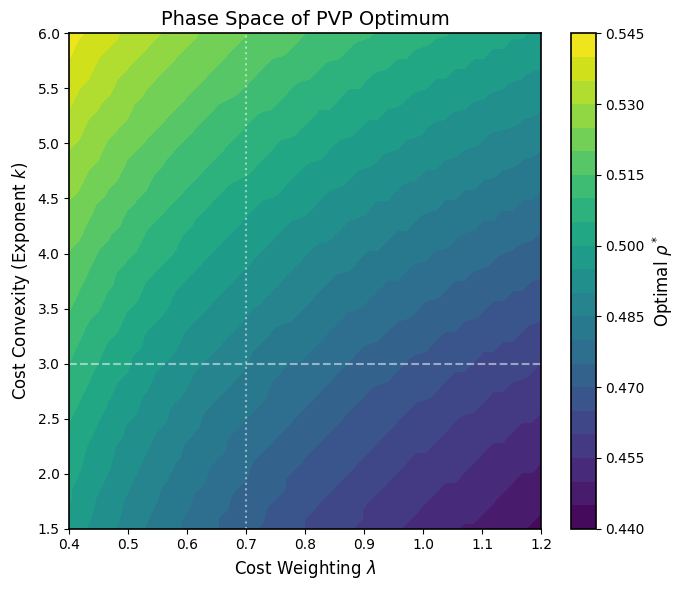

In [5]:
"""
PVP Simulation: Biological Regime + Sensitivity Analysis
Pump-Leak Model (Simplified Tosteson-Hoffman)

Author: Alberto A. Duarte, Paradox Systems
Date: December 2025

Objective:
1. Simulate the base model for Figure 1.
2. Perform sensitivity analysis to demonstrate robustness against variations
   in the functional form of G(ρ) and C(ρ).
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Style configuration for scientific plotting
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 1.2

def get_functions(rho, cost_exp=3.0, steepness=20, threshold=0.30):
    """
    Generates the parameterized G and C functions.

    Args:
        rho (array): State vector [0,1].
        cost_exp (float): Cost exponent. >1 indicates convex cost.
                          (Standard Pump-Leak ≈ 3.0)
        steepness (float): Slope of the stability sigmoid.
        threshold (float): Midpoint of the stability transition.
    """
    # G(ρ): Sigmoid
    G = 1.0 / (1.0 + np.exp(-steepness * (rho - threshold)))

    # C(ρ): Normalized Exponential
    # If cost_exp is very low (≈1), the cost is almost linear.
    C = (np.exp(cost_exp * rho) - 1) / (np.exp(cost_exp) - 1)

    return G, C

def run_standard_model():
    """
    Runs the model with standard parameters for the primary visualization.
    """
    print("\n--- RUNNING STANDARD MODEL ---")
    rho = np.linspace(0.00, 1.00, 1000)

    # Standard parameters
    params = {'cost_exp': 3.0, 'steepness': 20, 'threshold': 0.30}
    lambda_cost = 0.7

    G, C = get_functions(rho, **params)
    W = G - lambda_cost * C

    # Normalization for visualization
    W_norm = (W - W.min()) / (W.max() - W.min())

    # Metrics
    idx_opt = np.argmax(W)
    rho_opt = rho[idx_opt]

    # Plotting Figure 1
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(rho, G, '--', color='green', label='Gain (Stability) $G$')
    ax.plot(rho, C, ':', color='red', label='Cost (ATP) $C$')
    ax.plot(rho, W_norm, '-', color='blue', linewidth=3, label='Viability $W$')

    # Decoration
    ax.axvline(rho_opt, color='k', linestyle=':', alpha=0.5)
    ax.scatter([rho_opt], [W_norm[idx_opt]], color='blue', zorder=5, s=100)
    ax.text(rho_opt + 0.05, 1.02, f'$\\rho^* = {rho_opt:.3f}$', fontsize=12, fontweight='bold')

    # PRS Zones (Paradox Risk Syndrome / Exhaustion)
    ax.fill_between(rho, 0, 1.2, where=(rho > 0.8), color='gray', alpha=0.2, label='PRS Zone (Exhaustion)')

    ax.set_title('Standard Pump-Leak Model', fontsize=14)
    ax.set_xlabel('Degree of Systemic Closure ($\\rho$)', fontsize=12)
    ax.set_ylabel('Normalized Magnitude', fontsize=12)
    ax.set_ylim(0, 1.15)
    ax.set_xlim(0, 1)
    ax.legend(loc='center right')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    print(f"Standard optimum found at rho = {rho_opt:.3f}")

def run_sensitivity_analysis():
    """
    Generates the Robustness Figure.
    Varies cost exponents and gain slopes to demonstrate that the interior
    optimum ρ* persists regardless of exact parameters.
    """
    print("\n--- RUNNING SENSITIVITY ANALYSIS ---")

    rho = np.linspace(0.00, 1.00, 1000)
    lambda_cost = 0.7

    # Configuration of variations
    cost_exponents = [1.5, 3.0, 5.0]  # From almost linear to very convex
    steepnesses = [10, 20, 50]        # From smooth transition to step

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- PANEL A: Variation of Cost Convexity ---
    ax1 = axes[0]
    colors = cm.autumn_r(np.linspace(0.2, 1, len(cost_exponents)))

    for i, exp_k in enumerate(cost_exponents):
        G, C = get_functions(rho, cost_exp=exp_k, steepness=20) # Steepness fixed
        W = G - lambda_cost * C
        W_norm = (W - W.min()) / (W.max() - W.min()) # Normalize to compare peaks

        rho_opt = rho[np.argmax(W)]

        label = f'Cost Exp $k={exp_k}$ ($\\rho^*={rho_opt:.2f}$)'
        ax1.plot(rho, W_norm, linewidth=2.5, color=colors[i], label=label)
        ax1.scatter([rho_opt], [1.0], color=colors[i], s=50)

    ax1.set_title('Robustness A: Varying Cost Convexity', fontweight='bold')
    ax1.set_xlabel('$\\rho$ (Closure)', fontsize=12)
    ax1.set_ylabel('Normalized Viability $W$', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.text(0.05, 0.5, "Even with low costs,\nthe optimum is interior", transform=ax1.transAxes, fontsize=9, style='italic')

    # --- PANEL B: Variation of Gain Slope ---
    ax2 = axes[1]
    colors = cm.winter(np.linspace(0.2, 1, len(steepnesses)))

    for i, steep in enumerate(steepnesses):
        G, C = get_functions(rho, cost_exp=3.0, steepness=steep) # Cost fixed
        W = G - lambda_cost * C
        W_norm = (W - W.min()) / (W.max() - W.min())

        rho_opt = rho[np.argmax(W)]

        label = f'Slope $s={steep}$ ($\\rho^*={rho_opt:.2f}$)'
        ax2.plot(rho, W_norm, linewidth=2.5, color=colors[i], label=label)
        ax2.scatter([rho_opt], [1.0], color=colors[i], s=50)

    ax2.set_title('Robustness B: Varying Stability Transition', fontweight='bold')
    ax2.set_xlabel('$\\rho$ (Closure)', fontsize=12)
    ax2.set_ylabel('Normalized Viability $W$', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Key message
    plt.suptitle('Sensitivity Analysis: Persistence of Interior Optimum\n(PVP Robustness Validation)',
                 fontsize=14, y=1.02)

    plt.tight_layout()
    plt.savefig('robustness_check.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Robustness figure saved as 'robustness_check.png'")

def run_heatmap_analysis():
    """
    Generates a heatmap of optimal rho* varying both parameters.
    This provides a comprehensive view of the solution space.
    """
    print("\n--- GENERATING OPTIMA HEATMAP ---")

    exps = np.linspace(1.5, 6.0, 50)
    lams = np.linspace(0.4, 1.2, 50)

    rho_opts = np.zeros((len(exps), len(lams)))
    rho_vector = np.linspace(0, 1, 1000)

    for i, k in enumerate(exps):
        for j, lam in enumerate(lams):
            G, C = get_functions(rho_vector, cost_exp=k, steepness=20)
            W = G - lam * C
            rho_opts[i, j] = rho_vector[np.argmax(W)]

    plt.figure(figsize=(7, 6))
    plt.contourf(lams, exps, rho_opts, levels=20, cmap='viridis')
    cbar = plt.colorbar()
    cbar.set_label('Optimal $\\rho^*$', fontsize=12)

    plt.title('Phase Space of PVP Optimum', fontsize=14)
    plt.xlabel('Cost Weighting $\\lambda$', fontsize=12)
    plt.ylabel('Cost Convexity (Exponent $k$)', fontsize=12)
    plt.axhline(3.0, color='white', linestyle='--', alpha=0.5, label='Std Model')
    plt.axvline(0.7, color='white', linestyle=':', alpha=0.5)

    plt.tight_layout()
    plt.savefig('optima_heatmap.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    # 1. Run base simulation (for reference)
    run_standard_model()

    # 2. Run robustness analysis (Panel A and B)
    run_sensitivity_analysis()

    # 3. Run heatmap
    run_heatmap_analysis()